In [10]:
import pandas as pd
import numpy as np
from numpy import vectorize
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from time import time

import plotly

import plotly.plotly as py
import plotly.graph_objs as go

from ratings.Elo import Elo
from ratings.helpers import log_loss
from ratings.helpers import squared_error

from ratings.Rate import Rate
from scipy import stats

### Data issues: 
2012/13 Bundesliga season starts in Jan 2013
2011/2012 Bundesliga season has a fixture in 2015

### Modelling Conclusions:
For Bundesliga:
- Logistic: Calculations completed in 70.774069 seconds with a log loss of 0.279777 and a mean squared error of 0.165505
- Five-thirty-eight: Calculations completed in 79.368154 seconds with a log loss of 0.279479 and a mean squared error of 0.165106
- seems like regressing to mean is not a good approach

General conclusions:
- k of 20, h of 70, Sd=True seems to be a good setting for a lot of major leagues
- Glicko not as good as a well-tuned Elo?

In [11]:
fixtures = pd.read_csv('soccer_data.csv')

In [12]:
#Use Champions League to test
fixtures_f = fixtures[(fixtures['league_name'] == 'Premier League') & (fixtures['country_name'] == 'England')]

In [13]:
rating = Rate()

In [14]:
#log_loss = []
#squared_error = []
#Sd_methods = ["Logistic", "Power", "538"]
#for method in Sd_methods:
#log_loss.append(bundesliga.log_loss)
#squared_error.append(bundesliga.squared_error)

#Calculations completed in 50.906233 seconds with a log loss of 0.277650 and a mean squared error of 0.165147 (k of 20, h of 70, Sd=True)
#Premier league: Calculations completed in 83.123719 seconds with a log loss of 0.268767 and a mean squared error of 0.150653 (k of 20, h of 70, Sd=True)

rating.calculate_elo(fixtures_f, K=20, h=50, Sd=True) 

Prepping data...
Starting calculations...
Calculations completed in 80.976509 seconds==================] 100.0% ... Hooray!


In [15]:
fixtures_f = fixtures_f.join(rating.ratings_fixtures)

### Extrapolating the three-way probability from two-way probability
In order to calculate the three-way probability, we extrapolate the outcomes based on the home win probability, using lines of best fit

In [17]:
x = rating.ratings_fixtures['localteam_p'].values

y_tie = np.where(fixtures_f['outcome']==0.5, 1, 0)
y_home = np.where(fixtures_f['outcome']==1, 1, 0)
y_away = np.where(fixtures_f['outcome']==0, 1, 0)

In [18]:
nbins = 50

y_binned_h, x_bins_h = np.histogram(x, bins=nbins, weights=y_home)
y_total_h, x_bins_h = np.histogram(x, bins=nbins)

y_binned_a, x_bins_a = np.histogram(x, bins=nbins, weights=y_away)
y_total_a, x_bins_a = np.histogram(x, bins=nbins)

y_binned_t, x_bins_t = np.histogram(x, bins=nbins, weights=y_tie)
y_total_t, x_bins_t = np.histogram(x, bins=nbins)

In [19]:
mask_h = y_total_h > 15
mask_a = y_total_a > 15
mask_t = y_total_t > 15

y_binned_h = y_binned_h[mask_h]
y_binned_a = y_binned_a[mask_a]
y_binned_t = y_binned_t[mask_t]

y_total_h = y_total_h[mask_h]
y_total_a = y_total_a[mask_a]
y_total_t = y_total_t[mask_t]

x_bins_h = x_bins_h[1:][mask_h]
x_bins_a = x_bins_a[1:][mask_a]
x_bins_t = x_bins_t[1:][mask_t]

In [20]:
mean_h = np.divide(y_binned_h, y_total_h)
mean_h[np.isnan(mean_h)]=0

mean_a = np.divide(y_binned_a, y_total_a)
mean_a[np.isnan(mean_a)]=0

mean_t = np.divide(y_binned_t, y_total_t)
mean_t[np.isnan(mean_t)]=0

In [23]:
z_h = np.polyfit(x_bins_h, mean_h, 2)
p_h = np.poly1d(z_h)

z_a = np.polyfit(x_bins_a, mean_a, 2)
p_a = np.poly1d(z_a)

z_t = np.polyfit(x_bins_t, mean_t, 2)
p_t = np.poly1d(z_t)

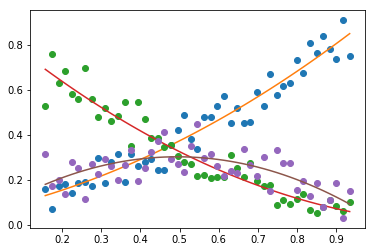

In [24]:
line_h = p_h(x_bins_h)
plt.plot(x_bins_h, mean_h ,'o', x_bins_h, line_h)

line_a = p_a(x_bins_a)
plt.plot(x_bins_a, mean_a ,'o', x_bins_a, line_a)

line_t = p_t(x_bins_t)
plt.plot(x_bins_t, mean_t ,'o', x_bins_t, line_t)

In [25]:
def three_way_probability(p):
    #p_home = slope_h * p + i_h
    #p_away = slope_a * p + i_a
    
    p_tie =  p_t(p)
    p_away =  p_a(p)
    p_home = p_h(p)

    return p_home, p_away, p_tie

In [26]:
p_home, p_away, p_tie = three_way_probability(x)

In [27]:
p_total = p_home + p_away + p_tie

### Distribution of actual outcomes vs. Predictions

In [28]:
total = len(fixtures_f)

outcome_counts = fixtures_f['outcome'].value_counts()
outcome_dist = outcome_counts / total
print(outcome_counts)
print(outcome_dist)

1.0    1560
0.0     993
0.5     878
Name: outcome, dtype: int64
1.0    0.454678
0.0    0.289420
0.5    0.255902
Name: outcome, dtype: float64


In [29]:
print(np.mean(p_home))
print(np.mean(p_away)) #overestimating away probability
print(np.mean(p_tie)) #underestimating tie probability

0.443910229559
0.299011066399
0.257078704041


### Confusion Matrix

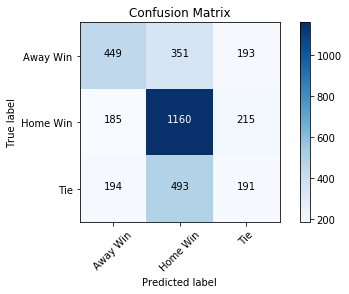

array([[ 449,  351,  193],
       [ 185, 1160,  215],
       [ 194,  493,  191]], dtype=int64)

In [30]:
rating.get_confusion_matrix()

### Precision, Recall, and f1-score

In [33]:
print(rating.get_classification_report())

             precision    recall  f1-score   support

   Away Win       0.54      0.45      0.49       993
   Home Win       0.58      0.74      0.65      1560
        Tie       0.32      0.22      0.26       878

avg / total       0.50      0.52      0.50      3431



### ROC

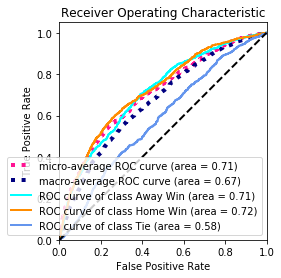

{'Away Win': 0.70942694843015519,
 'Home Win': 0.71866085568627647,
 'Tie': 0.57886496479642968,
 'macro': 0.66921400958693467,
 'micro': 0.70502302076978973}

In [35]:
rating.get_roc()

### Log Loss

In [36]:
rating.get_log_loss()

1.5087469848326158

### Predictive Power for latest set of matches

In [209]:
last_ratings = rating.ratings_teams_fixtures.groupby('team_id').last()
s = last_ratings['outcome'].values
p = last_ratings['team_p'].values

In [138]:
log_loss(s, p)

0.24635003200955796

# Graphing Results in Plot.ly

In [43]:
#Top teams
rating.ratings_teams.head(10)

,team_name,rating
team_id,,
9.0,Manchester City,1876.755076
6.0,Tottenham Hotspur,1792.140726
14.0,Manchester United,1761.182772
8.0,Liverpool,1751.869369
18.0,Chelsea,1703.108883
19.0,Arsenal,1670.842908
13.0,Everton,1563.119317
51.0,Crystal Palace,1555.639173
42.0,Leicester City,1543.214279


In [37]:
team_fixture_r = rating.ratings_teams_fixtures

In [38]:
teams = team_fixture_r.team_name.unique()

In [39]:
data = []

for team in teams:
    team_data = team_fixture_r[team_fixture_r['team_name'] == team]
    team_trace = go.Scatter(
        x = team_data.order,
        y = team_data.team_r,
        name = team,
        opacity = 0.8)
    data.append(team_trace)

In [40]:
fig = dict(data = data)
py.iplot(data)